In [1]:
import pandas as pd
import datetime
import math

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=8,progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Data prep

In [2]:
# Set file paths
file_path = '/Volumes/EnergyData/AER'
# Get YearMonth to FY mapping dict
YearMonthFY = pd.read_excel(f'{file_path}/Reference_data/duidinfo_SRMC.xlsx',
                         sheet_name='YearMonthFY').set_index(['Year','Month'])['FY'].to_dict()

In [3]:
# Set the start and end DI for each FY
FY_di_mapping = dict()
FY_di_mapping['FY2017_2018'] = [datetime.datetime(2017,7,1,0,5,0),datetime.datetime(2018,7,1,0,0,0)]
FY_di_mapping['FY2018_2019'] = [datetime.datetime(2018,7,1,0,5,0),datetime.datetime(2019,7,1,0,0,0)]
FY_di_mapping['FY2019_2020'] = [datetime.datetime(2019,7,1,0,5,0),datetime.datetime(2020,7,1,0,0,0)]
FY_di_mapping['FY2020_2021'] = [datetime.datetime(2020,7,1,0,5,0),datetime.datetime(2021,7,1,0,0,0)]
FY_di_mapping['FY2021_2022'] = [datetime.datetime(2021,7,1,0,5,0),datetime.datetime(2022,7,1,0,0,0)]
FY_di_mapping['FY2022_2023'] = [datetime.datetime(2022,7,1,0,5,0),datetime.datetime(2023,7,1,0,0,0)]
FY_di_mapping['FY2023_2024'] = [datetime.datetime(2023,7,1,0,5,0),datetime.datetime(2024,7,1,0,0,0)]

In [4]:
# Set bins and labels
bins = [-1100,-0.01,50,70,90,110,150,300,500,5000,20000]
labels = ['<0', '0_50', '50_70', '70_90','90_110',
          '110_150','150_300','300_500','500_5000','>5000']

# Define functions

In [5]:
def get_regional_duid_mapping(file_path,regionid):
    # Read the duid mapping table
    # It is obtained from Brian (from AER database)
    duid_mapping = pd.read_csv(f'{file_path}/Reference_data/duidinfo.csv',
                               usecols=['DUID','REGIONID','STATIONNAME','PARTICIPANTNAME',
                                        'DISPATCHTYPE','SCHEDULE_TYPE','FUELTYPE'])
    duid_mapping = duid_mapping[(duid_mapping['REGIONID']==regionid)&
                                (duid_mapping['SCHEDULE_TYPE'].isin(['SCHEDULED','SEMI-SCHEDULED']))&
                                (duid_mapping['DISPATCHTYPE']=='GENERATOR')]
    return duid_mapping.drop(columns=['DISPATCHTYPE','SCHEDULE_TYPE'])

In [6]:
def get_supply_curve_by_FY(supply_curve_path,FY_di_mapping,target_FY):
    supply_curve = pd.read_csv(supply_curve_path,
                               parse_dates=['SETTLEMENTDATE'])
    start_di = FY_di_mapping[target_FY][0]
    end_di = FY_di_mapping[target_FY][1]
    supply_curve = supply_curve[(supply_curve['SETTLEMENTDATE']>=start_di)&
                                (supply_curve['SETTLEMENTDATE']<=end_di)]
    return supply_curve

In [7]:
def generate_seasonality_tags(df):
    df['Year'] = df['SETTLEMENTDATE'].parallel_apply(lambda x: (x-datetime.timedelta(minutes=5)).year)
    df['Month'] = df['SETTLEMENTDATE'].parallel_apply(lambda x: (x-datetime.timedelta(minutes=5)).month)
    df['FY'] = df.parallel_apply(lambda row: YearMonthFY[(row['Year'],row['Month'])],axis=1)
    df['Quarter'] = df['Month'].parallel_apply(lambda x: 'Q'+str(math.ceil(x/3)))
    df['Hour'] = df['SETTLEMENTDATE'].parallel_apply(lambda x: (x-datetime.timedelta(minutes=5)).hour)
    return df

In [8]:
def get_di_counts(df):
    settlementdate_df = df[['SETTLEMENTDATE']].drop_duplicates()
    settlementdate_df = generate_seasonality_tags(settlementdate_df)
    di_counts = settlementdate_df.groupby(by=['FY','Year','Quarter','Month','Hour'],
                                          as_index=False,
                                          observed=True)\
                                          .count()\
                                          .rename(columns={'SETTLEMENTDATE':'DI_count'})
    return settlementdate_df,di_counts

Currently, I break the process into 2 stages and do the aggregation using Python, because the "pivot table on another pivot table" function is not available in Excel.

In [9]:
def aggregate_duid_offer_by_price_band(file_path,regionid,supply_type,
                                       YearMonthFY,FY_di_mapping,
                                       target_FY,bins,labels):
    # Get the DUID info for generator
    duid_mapping = get_regional_duid_mapping(file_path,regionid)
    # Set the path for the supply curve data
    supply_curve_path = f'{file_path}/Lerner_Index/Regional_{supply_type}_Supply_Curve_{regionid}_breakdown.csv'
    
    # Read supply curve data
    supply_curve = get_supply_curve_by_FY(supply_curve_path,FY_di_mapping,target_FY)
    
    try:
        supply_curve.rename(columns={'AVAILABILITY':'Bid_Avails',
                                     'SRMC':'Bid_Prices'},
                            inplace=True)
    except:
        pass
    
    # Get the DI seasonality mapping and 
    settlementdate_df,di_counts = get_di_counts(supply_curve)
    
    # Bin the offer price
    supply_curve['Price_band'] = pd.cut(supply_curve['Bid_Prices'],
                                        bins=bins, labels=labels, include_lowest=False)
    supply_curve = supply_curve.drop(columns=['Bid_Prices'])
    # Low-level aggregation
    supply_curve = supply_curve.groupby(by=['SETTLEMENTDATE','DUID','Price_band'],
                                        as_index=False,
                                        observed=True)[['Bid_Avails']].sum()
    
    # Tag seasonality features
    supply_curve = supply_curve.merge(right=settlementdate_df,
                                  on=['SETTLEMENTDATE'],
                                  how='left')
    # Aggregate on a DUID, [FY, Year, Quarter, Month, Hour] and Price_band basis
    supply_curve = supply_curve.groupby(by=['DUID','FY','Year','Quarter','Month','Hour','Price_band'],
                                        observed=True,
                                        as_index=False)[['Bid_Avails']].sum()
    # Reshape the dataframe
    temp_supply = supply_curve.pivot_table(index=['DUID',
                                                  'FY','Year','Quarter','Month','Hour'],
                                           columns='Price_band',
                                           values='Bid_Avails',
                                           observed=True).fillna(0).reset_index(drop=False)
    
    duid_di_counts = pd.DataFrame()
    for duid in temp_supply['DUID'].unique():
        temp = di_counts.copy()
        temp['DUID'] = duid
        duid_di_counts = pd.concat([duid_di_counts,temp])
    
    temp_supply_updated = duid_di_counts.merge(right=temp_supply,
                                               on=['DUID','FY','Year','Quarter','Month','Hour'],
                                               how='left').fillna(0)
    
        # Tag with duid info
    temp_supply_updated = temp_supply_updated.merge(right=duid_mapping,
                                                    on=['DUID'],
                                                    how='left')
    
        
    return temp_supply_updated

In [10]:
def further_aggregate_supply_data(supply_df,labels,aggregate_on,average_on):
    # Set up aggregation levels
    agg_dict = dict()
    for label in labels:
        agg_dict[label] = 'sum'
    agg_dict['DI_count'] = 'mean'

    avg_dict = dict()
    for label in labels:
        avg_dict[label] = 'sum'
    avg_dict['DI_count'] = 'sum'
    
    # Match the price bands between ACTUAL and SRMC
    for label in labels:
        if label not in supply_df.columns:
            supply_df[label] = 0
    
    # Initialise groupby params
    groupby1 = ['FY','Year','Quarter','Month','Hour']
    groupby2 = []
    groupby1.extend(aggregate_on)
    groupby2.extend(average_on)
    groupby2.extend(aggregate_on)
    
    results = supply_df.groupby(by=groupby1,as_index=False,observed=True)\
                       .agg(agg_dict)\
                       .groupby(by=groupby2,as_index=False,observed=True)\
                       .agg(avg_dict)
    # Calculate average
    for label in labels:
        results[label] = results[label]/results['DI_count']
        results[label] = results[label].round(2)
    
    return results

# Workflow

## test

[]

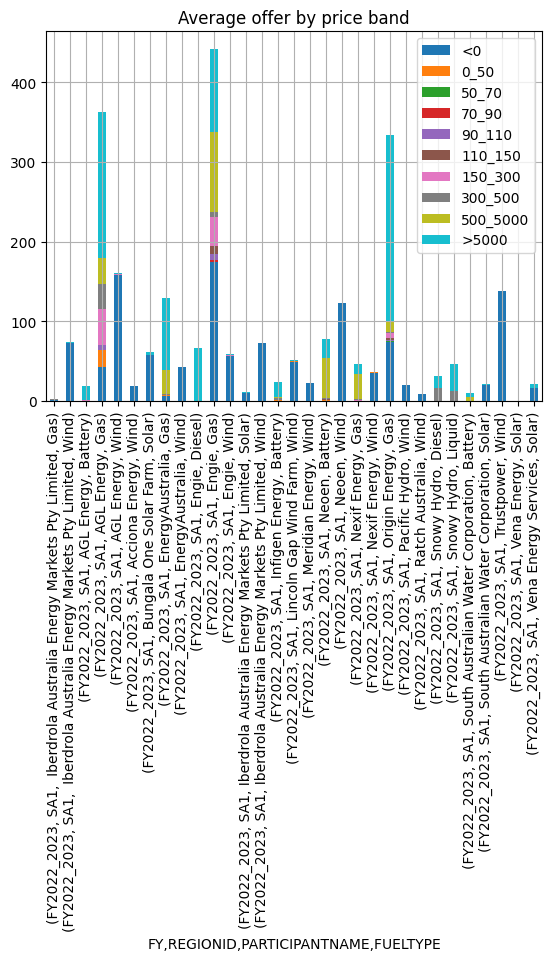

In [20]:
regionid = 'SA1'
supply_type = 'ACTUAL'
target_FY = 'FY2022_2023'

temp_supply = aggregate_duid_offer_by_price_band(file_path,regionid,supply_type,
                                                 YearMonthFY,FY_di_mapping,
                                                 target_FY,bins,labels)

aggregate_on = ['REGIONID','PARTICIPANTNAME','FUELTYPE']
average_on = ['FY']

temp_results = further_aggregate_supply_data(temp_supply,labels,aggregate_on,average_on)

ax = temp_results.drop(columns=['DI_count'])\
                 .set_index(['FY','REGIONID','PARTICIPANTNAME','FUELTYPE'])\
                 .plot.bar(stacked=True,grid=True)
ax.set_title("Average offer by price band",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [21]:
temp_results

,FY,REGIONID,PARTICIPANTNAME,FUELTYPE,<0,0_50,50_70,70_90,90_110,110_150,150_300,300_500,500_5000,>5000,DI_count
0,FY2022_2023,SA1,Iberdrola Australia Energy Markets Pty Limited,Gas,0.77,0.00,0.00,0.00,0.00,0.00,0.67,0.47,0.05,0.02,104544.0
1,FY2022_2023,SA1,Iberdrola Australia Energy Markets Pty Limited,Wind,72.10,0.07,0.11,0.00,0.00,0.00,0.01,0.00,0.04,1.22,104544.0
2,FY2022_2023,SA1,AGL Energy,Battery,0.17,0.05,0.02,0.00,0.13,0.11,0.83,0.00,0.23,17.11,104544.0
3,FY2022_2023,SA1,AGL Energy,Gas,43.19,21.02,0.00,0.00,6.06,0.00,45.47,31.59,32.05,183.16,104544.0
4,FY2022_2023,SA1,AGL Energy,Wind,158.08,0.35,0.04,0.00,0.00,0.00,1.11,0.25,0.04,0.90,104544.0
5,FY2022_2023,SA1,Acciona Energy,Wind,18.72,0.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,104544.0
6,FY2022_2023,SA1,Bungala One Solar Farm,Solar,57.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.81,104544.0
7,FY2022_2023,SA1,EnergyAustralia,Gas,6.75,1.02,0.00,0.00,0.00,0.00,0.00,1.50,29.65,90.10,104544.0
8,FY2022_2023,SA1,EnergyAustralia,Wind,42.58,0.07,0.00,0.00,0.00,0.00,0.04,0.00,0.01,0.04,104544.0
9,FY2022_2023,SA1,Engie,Diesel,0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,65.66,104544.0


## Generate data for analysis

In [11]:
def export_aggregated_supply(file_path,YearMonthFY,FY_di_mapping,bins,labels,
                             aggregate_on,average_on):
    filename = aggregate_on.copy()
    filename.extend(average_on)
    filename = '_'.join(filename)
    print(filename)
    
    for supply_type in ['SRMC','ACTUAL']:
        print(supply_type)
        results = pd.DataFrame()
        for regionid in ['NSW1','QLD1','VIC1','SA1']:
            print(regionid)
            for target_FY in FY_di_mapping.keys():
#                 print(target_FY)
                try:
                    temp_supply = aggregate_duid_offer_by_price_band(file_path,regionid,supply_type,
                                                                     YearMonthFY,FY_di_mapping,
                                                                     target_FY,bins,labels)
                    temp_supply_agg = further_aggregate_supply_data(temp_supply,labels,
                                                                    aggregate_on=aggregate_on,
                                                                    average_on=average_on)
                    results = pd.concat([results,temp_supply_agg])
                except:
                    print('Error',target_FY)
        results.to_csv(f'/Volumes/EnergyData/AER/Lerner_Index/aggregated_supply_{supply_type}_{filename}.csv',index=False)
    print('Done')
    return

In [13]:
aggregate_on = ['REGIONID','PARTICIPANTNAME','FUELTYPE','STATIONNAME']
average_on = ['FY']
export_aggregated_supply(file_path,YearMonthFY,FY_di_mapping,bins,labels,
                         aggregate_on,average_on)

REGIONID_PARTICIPANTNAME_FUELTYPE_STATIONNAME_FY
SRMC
NSW1
Error FY2023_2024
QLD1
Error FY2023_2024
VIC1
Error FY2023_2024
SA1
Error FY2023_2024
Done


In [14]:
aggregate_on = ['REGIONID','PARTICIPANTNAME','FUELTYPE','STATIONNAME']
average_on = ['FY','Year','Quarter']
export_aggregated_supply(file_path,YearMonthFY,FY_di_mapping,bins,labels,
                         aggregate_on,average_on)

REGIONID_PARTICIPANTNAME_FUELTYPE_STATIONNAME_FY_Year_Quarter
SRMC
NSW1
Error FY2023_2024
QLD1
Error FY2023_2024
VIC1
Error FY2023_2024
SA1
Error FY2023_2024
Done


In [42]:
aggregate_on = ['REGIONID','PARTICIPANTNAME','FUELTYPE','STATIONNAME']
average_on = ['FY','Year','Quarter','Month']
export_aggregated_supply(file_path,YearMonthFY,FY_di_mapping,bins,labels,
                         aggregate_on,average_on)

REGIONID_PARTICIPANTNAME_FUELTYPE_STATIONNAME_FY_Year_Quarter_Month
SRMC
NSW1
Error FY2023_2024
QLD1
Error FY2023_2024
VIC1
Error FY2023_2024
SA1
Error FY2023_2024
ACTUAL
NSW1
Error FY2023_2024
QLD1
Error FY2023_2024
VIC1
Error FY2023_2024
SA1
Error FY2023_2024
Done


In [15]:
aggregate_on = ['REGIONID','PARTICIPANTNAME','FUELTYPE','STATIONNAME']
average_on = ['FY','Hour']
export_aggregated_supply(file_path,YearMonthFY,FY_di_mapping,bins,labels,
                         aggregate_on,average_on)

REGIONID_PARTICIPANTNAME_FUELTYPE_STATIONNAME_FY_Hour
SRMC
NSW1
Error FY2023_2024
QLD1
Error FY2023_2024
VIC1
Error FY2023_2024
SA1
Error FY2023_2024
Done


In [16]:
aggregate_on = ['REGIONID','PARTICIPANTNAME','FUELTYPE','STATIONNAME']
average_on = ['FY','Year','Quarter','Hour']
export_aggregated_supply(file_path,YearMonthFY,FY_di_mapping,bins,labels,
                         aggregate_on,average_on)

REGIONID_PARTICIPANTNAME_FUELTYPE_STATIONNAME_FY_Year_Quarter_Hour
SRMC
NSW1
Error FY2023_2024
QLD1
Error FY2023_2024
VIC1
Error FY2023_2024
SA1
Error FY2023_2024
Done


In [41]:
aggregate_on = ['REGIONID','PARTICIPANTNAME','FUELTYPE','STATIONNAME']
average_on = ['FY','Year','Quarter']
export_aggregated_supply(file_path,YearMonthFY,FY_di_mapping,bins,labels,
                         aggregate_on,average_on)

REGIONID_PARTICIPANTNAME_FUELTYPE_STATIONNAME_FY_Year_Quarter
SRMC
NSW1
Error FY2023_2024
QLD1
Error FY2023_2024
VIC1
Error FY2023_2024
SA1
Error FY2023_2024
ACTUAL
NSW1
Error FY2023_2024
QLD1
Error FY2023_2024
VIC1
Error FY2023_2024
SA1
Error FY2023_2024
Done
